In [3]:
#plt sn都是畫圖套件
import matplotlib.pyplot as plt
import seaborn as sn 

#資料處理套件
import pandas as pd
import numpy as np

# keras 著重在深度學習
from tensorflow.keras.models import  Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# sklearn 也有深度學習但種類不多，主要以統計機器學習為主
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# 讓 keras跟 sklearn 互通
from keras.wrappers.scikit_learn import KerasClassifier

In [5]:
#資料前處裡
csv = pd.read_csv("stell-faults.csv")

data_col = csv.columns[:-7] #取出訓練資料的col
label_col = csv.columns[-7:] #取出標籤的col

# train
for i in data_col: #對資料做標準化 z-score
    col = csv[i]
    mean = col.mean() #取平均
    std = col.std()  #取標準差
    csv[i] = (csv[i] - mean) / std #標準化
    
train = csv[data_col]    #取出訓練資料
x_train = train.values   #pandas 轉成 numpy

# label
label = csv[label_col]   #取出標籤
y_train = label.values

#分割資料集 test_size分割比例
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

In [6]:
#　可自定義模型
#　不一定要用類神經網路，可以用 decision tree (進階版：random forest)、貝氏分類器...只要可以做分類的模型都可以
def create_model():
    
    # create model
    adam = optimizers.Adam(learning_rate=0.001) #類神經網路的優化器
    model = Sequential() #建立一個 keras的序列模型
    model.add(Dense(128, activation='relu')) #神經元數、激勵函數的種類
    model.add(Dropout(0.4)) #適時斷開某些神經元，避免overfitting，如果想知道更詳細 可以參考李弘毅的影片(youtube搜尋就有了)
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation='softmax'))#輸出層

    # loss損失函數 metrics評估標準
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['acc'])

    return model

In [7]:
#10-fold cross-validation 交叉驗證 - 驗證模型好壞

# 如果val_acc 40 Epoch 沒有變好 就停止
early_stop = EarlyStopping(monitor='val_acc', patience=40, verbose=0, mode="auto")

# build_fn 為一個會回傳keras model的 function
model = KerasClassifier(build_fn=create_model, epochs=2000, batch_size=20, validation_split=0.1, verbose=0, callbacks=[early_stop])  

# results 長度等於cv 的list 表示每次的結果
results = cross_val_score(model, x_train, y_train, cv=10)
print("10-fold cross-validation result accuracy：", sum(results)/10)

10-fold cross-validation result accuracy： 0.749673193693161


<AxesSubplot:>

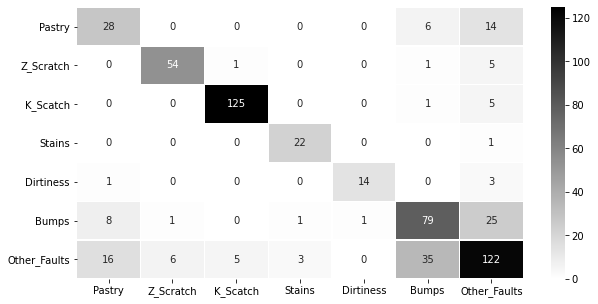

In [8]:
#confusion matrix 產生混淆矩陣

model = create_model() #回傳 keras model
early_stop = EarlyStopping(monitor='val_acc', patience=40, verbose=0, mode="auto")

#　model.fit就是開始訓練的意思
history = model.fit(x_train, y_train, epochs=2000, batch_size=200, validation_split=0.1, verbose=0, callbacks=[early_stop])


#產生混淆矩陣
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(x_test), axis=1))
df_cm = pd.DataFrame(matrix, index = [i for i in label_col], columns = [i for i in label_col])

#設定圖片大小 x y
plt.figure(figsize = (10,5))

# cmap顏色 linewidths要不要間格線條 annot要不要填數值進去 fmt科學記號
sn.heatmap(df_cm, cmap="binary", annot=True, linewidths=.2, fmt='g')

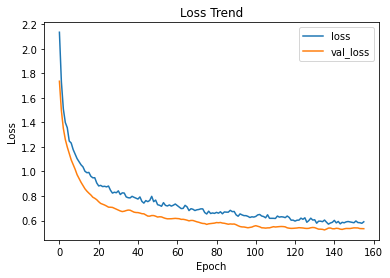

In [13]:
#混淆矩陣模型的訓練過程 _loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Loss Trend")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 0)
plt.show()

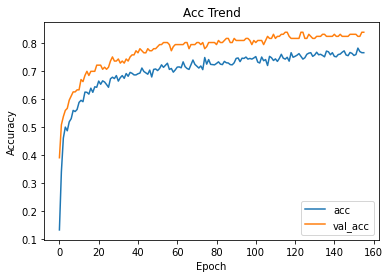

In [14]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.title("Acc Trend")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 0)
plt.show()